# Mountain Car Task

Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram below.

In [1]:
from IPython.display import Image

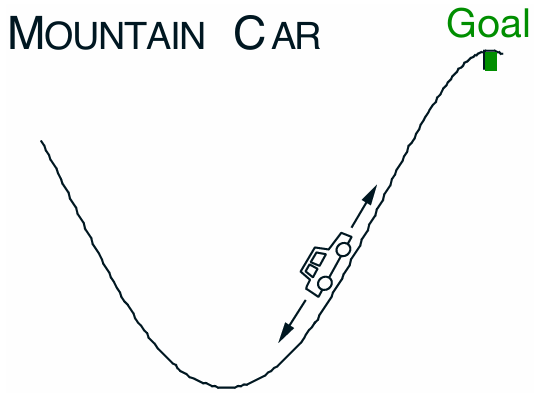

In [2]:
Image(filename="../book_images/Figure_10_1_upper_left.PNG")

The difficulty is that gravity is stronger than the car’s engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is:
1. move away from the goal and up the opposite slope on the left,
2. then, by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down
 the whole way.

- This is a simple example of a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better.
- Many control methodologies have great difficulties with tasks of this kind unless explicitly aided by a human designer.
- The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode.
- There are 3 possible actions:
  1. full throttle forward (+1),
  2. full throttle reverse (-1),
  3. zero throttle (0).
- The car moves according to a simplified physics. Its:
  - position, $x_t$, is updated by: $x_{t+1}\dot{=}bound[x_t+\dot{x}_{t+1}]$,
  - velocity, $\dot{x}_t$, is updated by: $\dot{x}_{t+1}\dot{=}bound[\dot{x}_t+0.001A_t-0.0025cos(3x_t)]$,
where the bound operation enforces:
  - $ -1.2 \leq x_{t+1} \leq 0.5 $,
  - $ -0.07 \leq \dot{x}_{t+1} \leq 0.07 $.
- In addition, when $x_{t+1}$ reached the:
  - left bound, $\dot{x}_{t+1}$ was reset to 0.
  - right bound, the goal was reached and the episode was terminated.
- Each episode started from a random position $ x_t \in [0.6; 0.4) $ and 0 velocity.

- To convert the 2 continuous state variables to binary features, we used grid-tilings as in Figure 9.9.
- We used 8 tilings, with each tile covering $1/8$th of the bounded distance in each dimension, and asymmetrical offsets as described in Section 9.5.4.
- The feature vectors $x(s,a)$ created by tile coding were then combined linearly with the parameter vector to approximate the action-value function: $ \hat{q} (s,a,\mathbf{w}) \dot{=} \mathbf{w}^T \mathbf{x}(s,a) = \sum\limits_{i=1}^d w_i \cdot x_i(s,a) $,  for each pair of state, $s$, and action, $a$.

Figure 10.1 shows what typically happens while learning to solve this task with this form of function approximation.
- Shown is the negative of the VF (the cost to-go function) learned on a single run.
- The initial action values were all 0, which was optimistic (all true values are negative in this task), causing extensive exploration to occur even though the exploration parameter, $\varepsilon$, was 0.
  - This can be seen in the middle-top panel of the figure, labeled “Step 428”.
  - At this time not even one episode had been completed, but the car has oscillated back and forth in the valley, following circular trajectories in state space.
  - All the states visited frequently are valued worse than unexplored states, because the actual rewards have been worse than what was (unrealistically) expected.
- This continually drives the agent away from wherever it has been, to explore new states, until a solution is found.

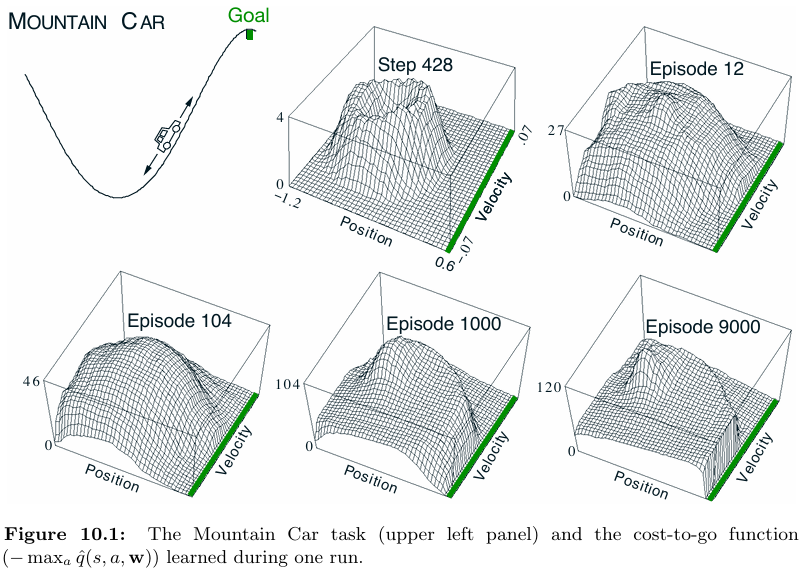

In [3]:
Image(filename="../book_images/Figure_10_1.PNG")

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.use('Agg')

In [5]:
from src.mountain_car import ValueFunction, semi_gradient_n_step_sarsa, print_cost

In [6]:
# Number of episodes
episodes = 9000

# Which episodes to plot
plot_episodes = [0, 99, episodes - 1]

In [7]:
# Set plot figure size
fig = plt.figure(figsize=(40, 10))

# Set plot figure axes
axes = [fig.add_subplot(1, len(plot_episodes), i+1, projection='3d') for i in range(len(plot_episodes))]

In [8]:
# Number of tilings
num_of_tilings = 8

# Step-size parameter
step_size = 0.3

# VF
value_function = ValueFunction(step_size, num_of_tilings)

In [9]:
# For every episode
for episode in tqdm(range(episodes)):
    # Semi-gradient n-step SARSA
    semi_gradient_n_step_sarsa(value_function)
    
    if episode in plot_episodes:
        print_cost(value_function, episode, axes[plot_episodes.index(episode)])

100%|██████████| 9000/9000 [00:57<00:00, 156.19it/s]


In [10]:
plt.savefig("../generated_images/figure_10_1.png")
plt.close()

Figure 10.2 shows several learning curves for semi-gradient SARSA on this problem, with various step sizes.

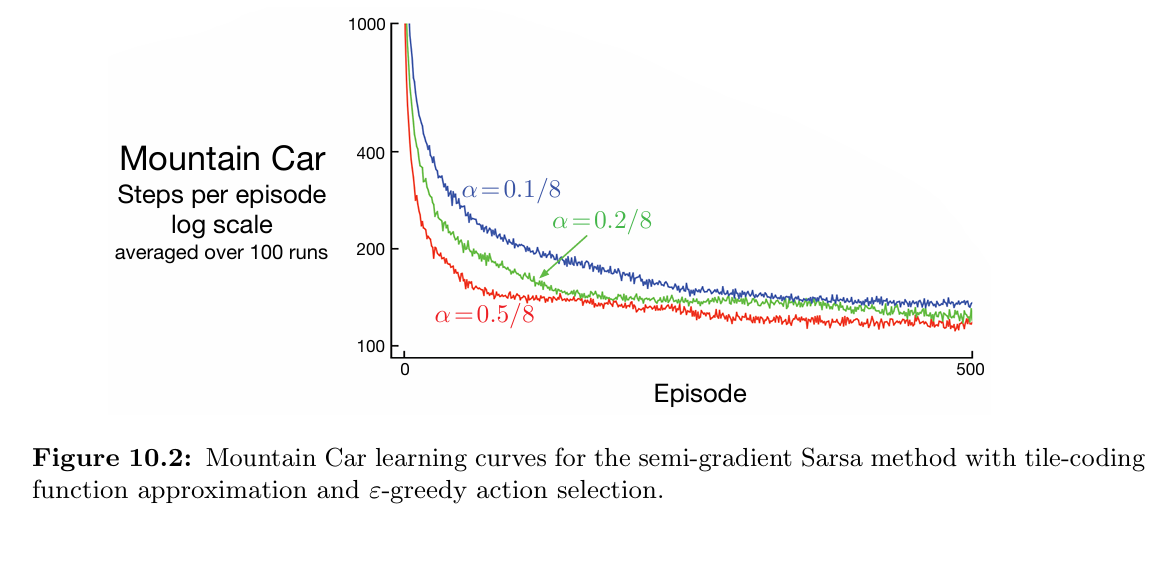

In [11]:
Image(filename="../book_images/Figure_10_2.PNG")

In [12]:
import numpy as np

In [13]:
# Number of runs
runs = 10

# Number of episodes
episodes = 500

In [14]:
# Number of tilings
num_of_tilings = 8

# List of step-size parameters
step_sizes = [0.1, 0.2, 0.5]

# Time steps matrix filled with 0s
time_steps = np.zeros((len(step_sizes), episodes))

In [15]:
# For every run
for run in range(runs):
    # initialize VFs
    value_functions = [ValueFunction(step_size, num_of_tilings) for step_size in step_sizes]
    
    # for every VF
    for index in range(len(value_functions)):
        # for every episode
        for episode in tqdm(range(episodes)):
            # calculate time step
            time_step = semi_gradient_n_step_sarsa(value_functions[index])
            
            # add time step to time steps matrix
            time_steps[index, episode] += time_step

100%|██████████| 500/500 [00:04<00:00, 115.42it/s]


In [16]:
# Average time steps over runs
time_steps /= runs

In [17]:
# Plotting
for i in range(len(step_sizes)):
    plt.plot(time_steps[i], label=r'$\alpha = $' + str(step_sizes[i]) + '/' + str(num_of_tilings))

plt.xlabel("Episode")
plt.ylabel(f"Steps per episode log scale averaged over {runs} runs")
plt.yscale("log")

plt.legend()

In [18]:
plt.savefig("../generated_images/figure_10_2.png")
plt.close()

## 1-step semi-gradient SARSA vs multistep semi-gradient SARSA

Figure 10.3 shows how episodic semi-gradient $n$-step SARSA algorithm tends to learn faster and obtain a better asymptotic performance at $n=8$ than at $n=1$ on the Mountain Car task.

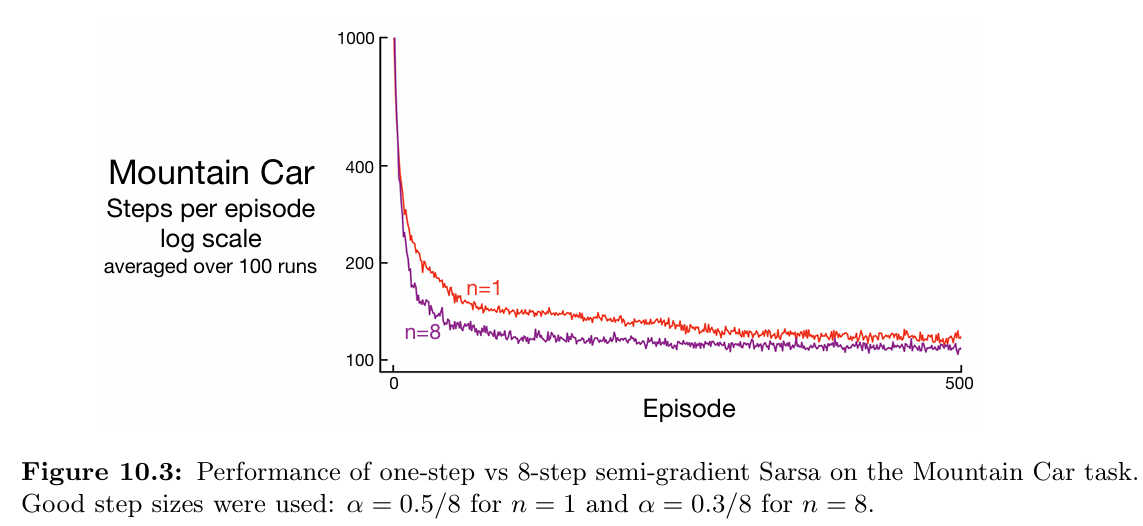

In [19]:
Image(filename="../book_images/Figure_10_3.PNG")

In [20]:
# Number of runs
runs = 10

# Number of episodes
episodes = 500

In [21]:
# Number of tilings
num_of_tilings = 8

# Step-size parameters
step_sizes = [0.5, 0.3]

In [22]:
# Number of steps (denoted as n)
n_steps = [1, 8]

# Create a matrix for time steps filled with 0s
time_steps = np.zeros((len(step_sizes), episodes))

In [23]:
# For every run
for run in range(runs):
    # initialize VFs
    value_functions = [ValueFunction(step_size, num_of_tilings) for step_size in step_sizes]
    
    # for every VF
    for index in range(len(value_functions)):
        # for every episode
        for episode in tqdm(range(episodes)):
            # calculate time step
            time_step = semi_gradient_n_step_sarsa(value_functions[index], n_steps[index])
            
            # add time step to time steps matrix
            time_steps[index, episode] += time_step

100%|██████████| 500/500 [00:03<00:00, 154.56it/s]


In [24]:
# Average time steps over runs
time_steps /= runs

In [25]:
# Plotting
for i in range(len(step_sizes)):
    plt.plot(time_steps[i], label=f'n = {n_steps[i]:.1f}')

plt.xlabel("Episode")
plt.ylabel(f"Steps per episode log scale averaged over {runs} runs")
plt.yscale("log")
plt.legend()

In [26]:
plt.savefig("../generated_images/figure_10_3.png")
plt.close()

## The effect of $\alpha$ and $n$ on multistep semi-gradient SARSA

Figure 10.4 shows the results of a more detailed study of the effect of the parameters $\alpha$ and $n$ on the rate of learning on this task.

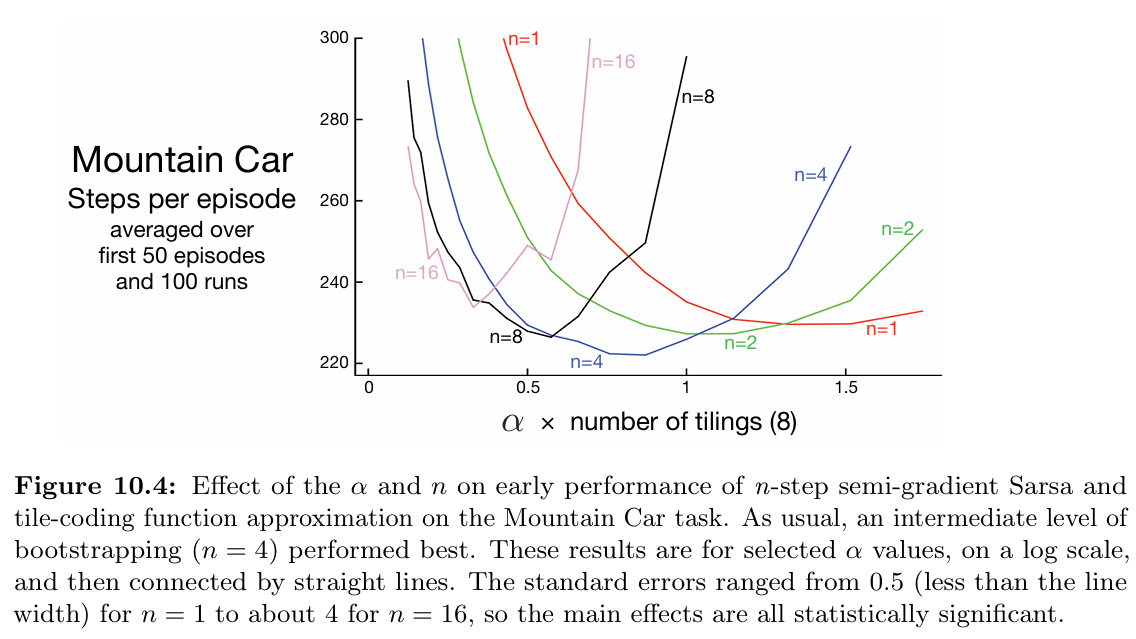

In [27]:
Image(filename="../book_images/Figure_10_4.PNG")

In [28]:
# Number of runs
runs = 5

# Number of episodes
episodes = 50

# Maximum number of steps
max_steps = 300

In [29]:
# Step-size parameters
step_sizes = np.arange(0.25, 1.75, 0.25)

# Number of steps
n_steps = np.power(2, np.arange(0, 5))

# Create a matrix for time steps filled with 0s
time_steps = np.zeros((len(n_steps), len(step_sizes)))

In [30]:
# For every run
for run in range(runs):
    # for every step number
    for n_step_index, n_step in enumerate(n_steps):
        # for every step-size
        for step_size_index, step_size in enumerate(step_sizes):
            if (n_step == 8 and step_size > 1) or (n_step == 16 and step_size > 0.75):
                # in these cases it won't converge, so ignore them
                time_steps[n_step_index, step_size_index] += max_steps * episodes
                continue
            
            # initialize VF
            value_function = ValueFunction(step_size)
            
            # for every episode
            for episode in tqdm(range(episodes)):
                # calculate time step
                time_step = semi_gradient_n_step_sarsa(value_function, n_step)
                
                # add time step to time steps matrix
                time_steps[n_step_index, step_size_index] += time_step

100%|██████████| 50/50 [00:00<00:00, 53.87it/s]


In [31]:
# Average over independent runs and episodes
time_steps /= runs * episodes

In [32]:
# Plotting
for i in range(0, len(n_steps)):
    plt.plot(step_sizes, time_steps[i, :], label='n = ' + str(n_steps[i]))

plt.xlabel(fr"$\alpha$ × number of tilings({num_of_tilings})")
plt.ylabel(f"Steps per episode averaged over first {episodes} episodes and {runs} runs")
plt.ylim([220, max_steps])
plt.legend()

In [33]:
plt.savefig("../generated_images/figure_10_4.png")
plt.close()